# Transferring parameters for MaxCut

A number of recent results show the power of QAOA parameter transferability, i.e. taking optimal parameters from one instances and using them on another one. In this notebook, we show how the data in `QAOAKit` can be used to reduce or completely avoid the need for parameter optimization on previously unseen instances.


In [1]:
import networkx as nx                                          
from pathlib import Path                 
import pandas as pd                      
import numpy as np                       
from tqdm import tqdm                    
tqdm.pandas()                            
                                         
from QAOAKit import (                
    beta_to_qaoa_format,                 
    gamma_to_qaoa_format,                
    qaoa_maxcut_energy,                  
)                  

## Step 0: load unseen graphs and optimal parameters for them

To evaluate the power of this method, we will consider 10 random Erdos-Renyi graphs for which we have previously optimized the parameters. This step can be skipped if you are trying to use parameters for your own graph!

In [2]:
from QAOAKit.examples_utils import get_20_node_erdos_renyi_graphs
df = get_20_node_erdos_renyi_graphs()

In [ ]:
# Optional: verify that the results in the dataset are correct (this may take a few minutes)

df['Energy reproduced'] = df.progress_apply(
    lambda row: qaoa_maxcut_energy(
            row["G"],
            beta_to_qaoa_format(row["beta"]),
            gamma_to_qaoa_format(row["gamma"]),
        ), axis = 1
)

assert(np.allclose(df['Energy reproduced'], df['QAOA energy with optimized parameters']))

## Step 1: grab a graph

Let's grab one graph from the benchmark and see how well transferred parameters work for it.

In [4]:
G = df.iloc[1]["G"]
optimized_energy = df.iloc[1]['QAOA energy with optimized parameters']
optimal_energy = df.iloc[1]['Optimal MaxCut solution from brute force']
p = df.iloc[1]['p_max']

## Step 3: compute median parameters

Median parameters have been shown to give good approximation ratios in Ref. [1]. Let's compute median parameters over all graphs with 9 nodes with this value of `p` and see how well it works for out much larger 20-node graph.

In [5]:
from QAOAKit import get_full_qaoa_dataset_table

df_full = get_full_qaoa_dataset_table().reset_index().set_index('graph_id')
df_full = df_full[(df_full['n'] == 9) & (df_full['p_max'] == p)]

data = df_full.apply(lambda x: np.hstack([np.array(x['gamma']), np.array(x['beta'])]), axis=1).values
data = np.stack(data)
median = np.median(data, axis=0)

## Step 4: plug in the median parametes and get the QAOA energy

In [6]:
transferred_energy = qaoa_maxcut_energy(G, beta_to_qaoa_format(median[p:]), gamma_to_qaoa_format(median[:p]))

How close are they?

In [7]:
print(f"Energy with median parameters: {transferred_energy}")
print(f"Energy with optimized parameters: {optimized_energy}")

print(f"Approximation ratio with median parameters: {transferred_energy / optimal_energy}")
print(f"Approximation ratio with optimized parameters: {optimized_energy / optimal_energy}")

Energy with median parameters: 53.89719437161661
Energy with optimized parameters: 55.059206194600954
Approximation ratio with median parameters: 0.7811187590089363
Approximation ratio with optimized parameters: 0.7979595100666805


That's pretty close!

## Did we get lucky?

Let's see if this holds for all 10 graphs in our dataset and all values of `p` in it.

In [8]:
medians = {}

# compute the median angles for all values of p
for p in tqdm(range(1,4)):
    df_full = get_full_qaoa_dataset_table().reset_index().set_index('graph_id')
    df_full = df_full[(df_full['n'] == 9) & (df_full['p_max'] == p)]

    data = df_full.apply(lambda x: np.hstack([np.array(x['gamma']), np.array(x['beta'])]), axis=1).values
    data = np.stack(data)
    medians[p] = np.median(data, axis=0)

# compute the energy with one of the three median QAOA parameters  
df['QAOA energy with median parameters'] = df.progress_apply(
    lambda row: qaoa_maxcut_energy(
        row['G'], 
        beta_to_qaoa_format(medians[row['p_max']][row['p_max']:]), 
        gamma_to_qaoa_format(medians[row['p_max']][:row['p_max']])
    ), axis=1
)

100%|██████████| 30/30 [07:56<00:00, 15.87s/it]


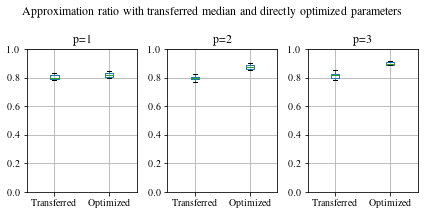

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
 
df['Transferred'] = df['QAOA energy with median parameters'] / df['Optimal MaxCut solution from brute force']
df['Optimized'] = df['QAOA energy with optimized parameters'] / df['Optimal MaxCut solution from brute force']
 
f, ax = plt.subplots(1,3, figsize=(6,3))
ps = [1,2,3]
for idx, p in enumerate(ps):
    df[df['p_max'] == p].boxplot(column=['Transferred', 'Optimized'], ax=ax[idx])
    ax[idx].set_title(f"p={p}")
    ax[idx].set_ylim(0,1)
f.suptitle("Approximation ratio with transferred median and directly optimized parameters")
plt.tight_layout()
plt.savefig("transferability.pdf")
plt.show()

In [10]:
for idx, p in enumerate(ps):
    print(f"Mean approximation ratios for p={p}:")
    print(df[df['p_max'] == p][['Transferred', 'Optimized']].mean())

Mean approximation ratios for p=1:
Transferred    0.804248
Optimized      0.821017
dtype: float64
Mean approximation ratios for p=2:
Transferred    0.798006
Optimized      0.875290
dtype: float64
Mean approximation ratios for p=3:
Transferred    0.813761
Optimized      0.899247
dtype: float64


Median parameters work well for all graphs in our dataset!

# References

[1] Lotshaw, Phillip C., et al. "Empirical performance bounds for quantum approximate optimization." arXiv:2102.06813 (2021).